# Leave-K-Studies-Out Analysis
- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/4_leave-k-studies-out.ipynb
- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature
- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3
- Raw data from center 3 is available upon reasonable request.

## Imports

In [1]:
import sys
sys.path.append('../')
from PAINTeR import connectivity # in-house lib used for the RPN-signature
from PAINTeR import plot # in-house lib used for the RPN-signature
from PAINTeR import model # in-house lib used for the RPN-signature
import numpy as np # hi old friend
import pandas as pd

from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure

from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from sklearn.linear_model import ElasticNet, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, KFold, GroupKFold, LeavePGroupsOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

from neurocombat_sklearn import CombatModel

import scipy.stats as stats
import joblib

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Load and merge behavioral data for all three centers (after exclusions)

In [2]:
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
df

,index,Unnamed: 0,ID,Excluded,exclusion_crit,Male,day_menses,Age,height,weight,...,weight..kg.,psq_moderate,psq_minor,PSQ20,PSQI,MDT_log_geom,Pulse_MRI,Pulse_QST,BDI,PSQ20_essen
0,0,0,4,0.0,NaN,1.0,NaN,25.552361,175.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,6,0.0,NaN,1.0,NaN,33.453799,183.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,7,0.0,NaN,1.0,NaN,26.119097,186.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,8,0.0,NaN,1.0,NaN,25.445585,180.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,9,0.0,NaN,0.0,6.0,22.573580,176.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,14,14,22,0.0,NaN,1.0,NaN,24.000000,185.0,82.0,...,NaN,27.0,11.0,6.0,1.0,-1.259900,73.0,76.0,5.0,24.0
87,15,15,24,0.0,NaN,1.0,NaN,22.000000,183.0,83.0,...,NaN,28.0,16.0,9.0,1.0,-1.913513,85.0,86.0,0.0,25.0
88,16,16,25,0.0,NaN,1.0,NaN,22.000000,195.0,77.0,...,NaN,20.0,9.0,11.0,NaN,-1.581106,88.0,91.0,1.0,25.0
89,17,17,28,0.0,NaN,0.0,5.0,23.000000,162.0,59.0,...,NaN,34.0,18.0,43.0,2.0,-1.145363,78.0,89.0,7.0,37.0


## Load preprocessed and scrubbed timeseries data

<AxesSubplot:>

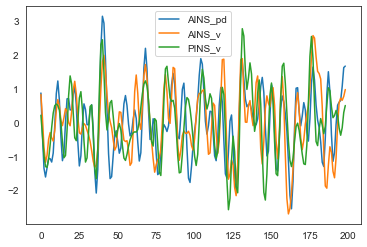

In [3]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'
    
    ts = pd.read_csv(f_scrub).iloc[:,1:] # here we can omit global signal...
    
    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd 
    
    perc_scrubbed.append(100 - 100*len(ts.shape)/len(fd) )
    timeseries.append(ts.values)
    
# double check visually
sub_idx=10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()

## Load region and module names for the MIST122 atlas

In [4]:
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

## Calculate functional connectivity as partial correlation

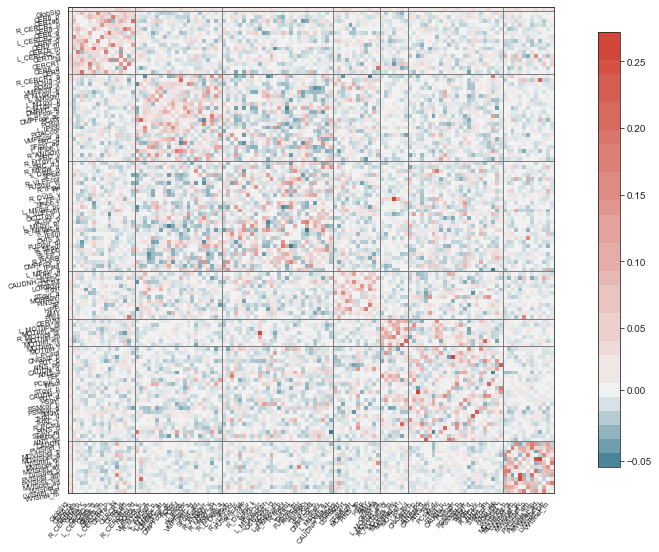

In [5]:
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
X = correlation_measure.fit_transform(timeseries) # these are the features

# double-check the mean matrix visually
mat=correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0 # zero diag
plot.plot_matrix(mat, labels, modules)

## Pain sensitivity as target variable

In [6]:
y = df.mean_QST_pain_sensitivity

## Define model to be trained

In [7]:
# an oversimplified factory-function, defining the model to be trained:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          p_grid={'fsel__k': [25, 50, 100, 1000, 3000],
                              'model__alpha': [.001, .005, .01, .05, .1, .5, 1, 5],
                              'model__l1_ratio': [0.0001, .25, .5, .75, 0.9999]         
                                   }):
                                      
    mymodel = Pipeline(
        [
         ('fsel', fsel),
         ('scaler', scaler),
         ('model', model)])
    return mymodel, p_grid

In [8]:
model, p_grid = pipe_scale_fsel_elnet()

## Nested leave-two-studies-out cross validation (L2SO)
I.e. training on one center only

In [14]:
# possible leakage, but can't do the combat transformation on unseen centers
comb = CombatModel()
X_combat = comb.fit_transform(X,
                            np.array([df.study.astype("category").cat.codes.values]).transpose(),
                            np.array([df.Male.values]).transpose(),
                            np.array([df.Age.values]).transpose()
                            )


outer_cv = LeavePGroupsOut(2) # LeaveTwoStudiesOut
inner_cv = LeaveOneOut() # LeaveOneOut, to maximize training samplke                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_combat, groups=df.study))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_combat, groups=df.study))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X_combat, y, groups=df.study):                               
    clf.fit(X_combat[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_combat[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_combat[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_combat[test], y[test])
    i = i+1


model	inner_cv mean score	outer vc score
Fitting 19 folds for each of 200 candidates, totalling 3800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 2312 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 2764 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3314 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3800 out of 3800 | elapsed: 15.1min finished


cv: 0 {'fsel__k': 100, 'model__alpha': 1, 'model__l1_ratio': 0.0001} -0.17846253425643932 -0.9629111538877021
Fitting 37 folds for each of 200 candidates, totalling 7400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 3044 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 3946 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 4759 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 5409 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 6159 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 7009 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 7400 out of 7400 | elapsed: 33.6min finished


cv: 1 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.0001} -0.5566688844093813 -0.6918108610828435
Fitting 35 folds for each of 200 candidates, totalling 7000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2460 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 4343 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4813 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 5363 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 6013 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 6763 tasks      | elapsed: 23.6min


cv: 2 {'fsel__k': 25, 'model__alpha': 0.005, 'model__l1_ratio': 0.5} -0.31414304684438094 -0.5045406881760552


[Parallel(n_jobs=-1)]: Done 7000 out of 7000 | elapsed: 24.1min finished


### Print out the unbiased, nested L2SO estimates and plot the (unbiased) nested-cv predictions

*** Score on mean as model:	-0.5655535039999882
** Mean score in the inner crossvaludation (inner_cv):	-0.3497581551700672
** Mean Nested Crossvalidation Score (outer_cv):	-0.7197542343822003
Explained Variance: -0.2726545398297371
Correlation: 0.28245152566576287


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


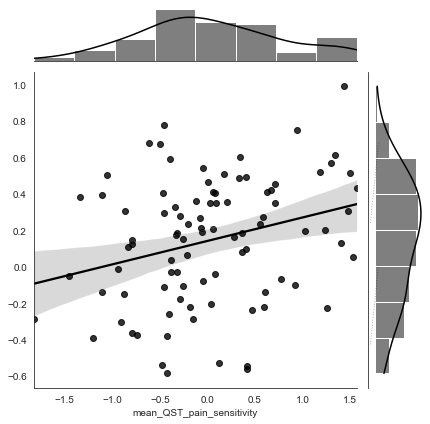

In [15]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

### Save the nested-cv predictions and the models

In [16]:
# save nested L2SO predictions
np.savetxt("../res/multi-center/nested_cv_pred_L1SO.csv", predicted, delimiter=",")

In [17]:
# szeged -> bochum + essen
joblib.dump(all_models[0], '../res/multi-center/model_trained_on_szeged.joblib')

# essen -> bochum + szeged
joblib.dump(all_models[1], '../res/multi-center/model_trained_on_essen.joblib')

# bochum -> essen + szeged
joblib.dump(all_models[2], '../res/multi-center/model_trained_on_bochum.joblib') # RPN-signature

['../res/multi-center/model_trained_on_bochum.joblib']

## Nested leave-one-study-out cross validation (L1SO)
I.e. training on one center only

In [18]:
# possible leakage, but can't do the combat transformation on unseen centers
comb = CombatModel()
X_combat = comb.fit_transform(X,
                            np.array([df.study.astype("category").cat.codes.values]).transpose(),
                            np.array([df.Male.values]).transpose(),
                            np.array([df.Age.values]).transpose()
                            )


outer_cv = LeavePGroupsOut(1) # LeaveOneStudyOut
inner_cv = LeaveOneOut() # LeaveOneOut, to maximize training samplke                                      
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_combat, groups=df.study))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_combat, groups=df.study))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X_combat, y, groups=df.study):                               
    clf.fit(X_combat[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_combat[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_combat[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_combat[test], y[test])
    i = i+1


model	inner_cv mean score	outer vc score
Fitting 56 folds for each of 200 candidates, totalling 11200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 2310 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 4410 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 5856 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 7014 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 8414 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 9264 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 10214 tasks      | elapsed: 48.2min
[Parallel(n_jobs=-1)]: Done 11200 out of 11200 | elapsed: 50.9min finished


cv: 0 {'fsel__k': 25, 'model__alpha': 0.5, 'model__l1_ratio': 0.75} -0.6154808307352211 -0.5209933598440423
Fitting 54 folds for each of 200 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 6679 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7332 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 8082 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 8932 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 9882 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 10800 out of 10800 | elapsed: 39.7min finished


cv: 1 {'fsel__k': 25, 'model__alpha': 5, 'model__l1_ratio': 0.0001} -0.4487699552859295 -0.836235683532116
Fitting 72 folds for each of 200 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 7088 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 8964 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 9714 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 10564 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 11514 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 12564 tasks      | elapsed: 47.5min
[Parallel(n_jobs=-1)]: Done 13714 tasks      | elapsed: 59.0min
[Parallel(n_jobs=-1)]: Done 14400 out of 14400 | elapsed: 61.1min finished


cv: 2 {'fsel__k': 25, 'model__alpha': 0.001, 'model__l1_ratio': 0.0001} -0.5442699970702684 -0.48372977490927055


### Print out the unbiased, nested estimates and plot the (unbiased) nested-cv predictions

*** Score on mean as model:	-0.5655535039999882
** Mean score in the inner crossvaludation (inner_cv):	-0.5361735943638063
** Mean Nested Crossvalidation Score (outer_cv):	-0.6136529394284763
Explained Variance: -0.08504842616710073
Correlation: -0.019910206789448864


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


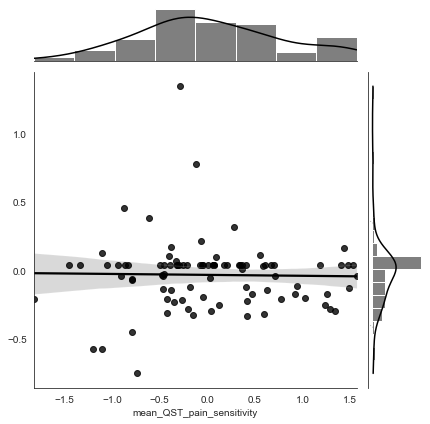

In [19]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

### Save the nested-cv predictions and the models

In [20]:
# save nested L2SO predictions
np.savetxt("../res/multi-center/nested_cv_pred_L2SO.csv", predicted, delimiter=",")

In [21]:
# essen+szeged -> bochum
joblib.dump(all_models[0], '../res/multi-center/model_trained_on_essen+szeged.joblib')

# bochum+szeged -> essen
joblib.dump(all_models[1], '../res/multi-center/model_trained_on_bochum+szeged.joblib')

# bochum+essen -> szeged
joblib.dump(all_models[2], '../res/multi-center/model_trained_on_bochum+essen.joblib')

['../res/multi-center/model_trained_on_bochum+essen.joblib']

## Analyze L2SO

In [22]:
#L2SO
predicted_l2so = np.genfromtxt("../res/multi-center/nested_cv_pred_L1SO.csv", delimiter=",")

Explained Variance:  0.15039434370123328
Correlation:  0.3979439264050382
p = 0.001


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


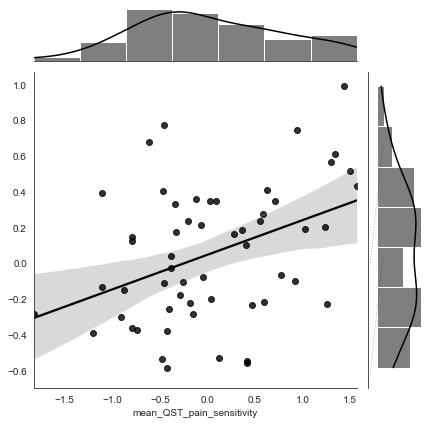

In [23]:
from mlxtend.evaluate import permutation_test
y_true = y[df.study!='bochum']
y_hat = predicted_l2so[df.study!='bochum']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])

Explained Variance:  0.054704824219912185
Correlation:  0.28645067920818335
p = 0.01875


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


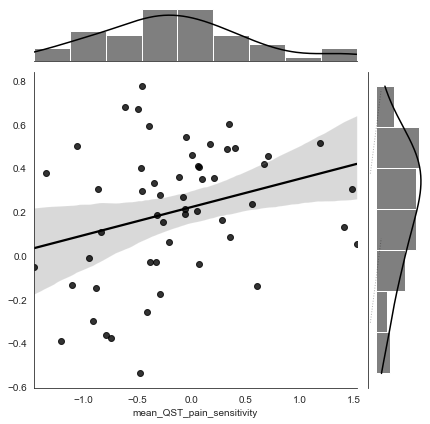

In [24]:
y_true = y[df.study!='essen']
y_hat = predicted_l2so[df.study!='essen']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])

Explained Variance:  0.005546878432592273
Correlation:  0.2206869582546932
p = 0.03375


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


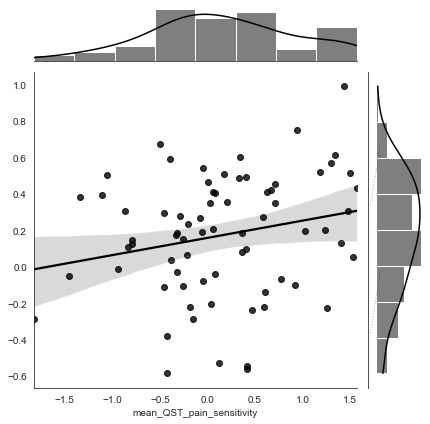

In [25]:
y_true = y[df.study!='szeged']
y_hat = predicted_l2so[df.study!='szeged']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])

In [26]:
p_corr = permutation_test(y, predicted_l2so,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                

p = 0.002875


## Analyze L1SO


In [27]:
#L1SO
predicted_l1so = np.genfromtxt("../res/multi-center/nested_cv_pred_L2SO.csv", delimiter=",") # typo in name

Explained Variance:  -2.220446049250313e-16
Correlation:  -2.859870710516705e-17
p = 0.501125


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


LinAlgError: singular matrix

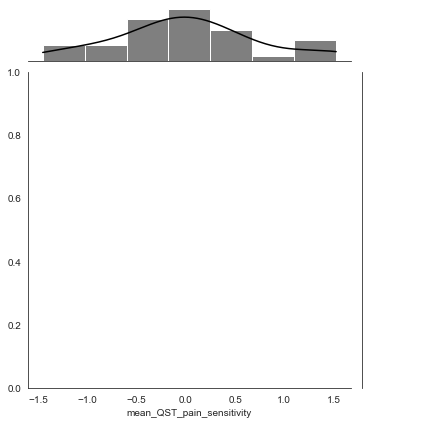

In [28]:
from mlxtend.evaluate import permutation_test
y_true = y[df.study=='bochum']
y_hat = predicted_l1so[df.study=='bochum']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])

Explained Variance:  -0.03653183423890183
Correlation:  -0.035735960126179314
p = 0.57775


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


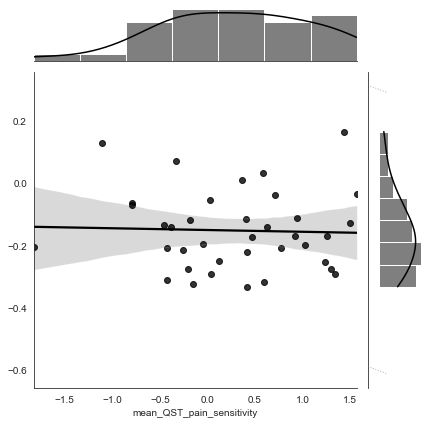

In [29]:
y_true = y[df.study=='essen']
y_hat = predicted_l1so[df.study=='essen']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])

Explained Variance:  -0.16399091564895096
Correlation:  0.4625297641649058
p = 0.022125


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


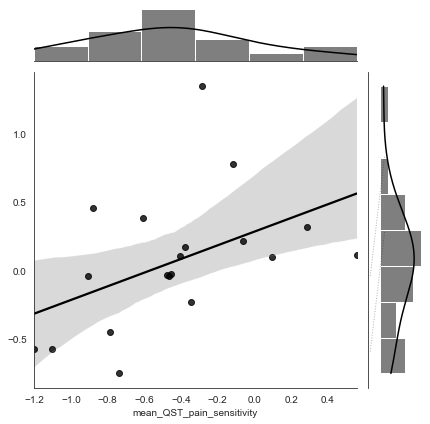

In [30]:
y_true = y[df.study=='szeged']
y_hat = predicted_l1so[df.study=='szeged']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])